In [ ]:
pip install --upgrade pip

In [ ]:
pip install -qU "langchain[openai]"

In [ ]:

pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"): 
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter api key for OPENAI: ")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter api key for Langsmith: ")

from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4.1-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


In [ ]:
pip install -qU langchain-core

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore
vectore_Store = InMemoryVectorStore(embeddings)

In [ ]:
pip install langgraph

In [10]:
os.environ["USER_AGENT"]='my-agent'

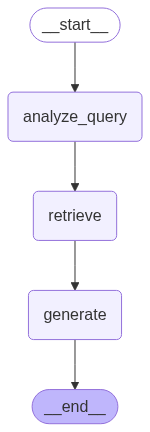

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict
from typing import Literal

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Update metadata for visual chain representation
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

_ = vectore_Store.add_documents(documents=all_splits)

class Search(TypedDict):
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

prompt = hub.pull("rlm/rag-prompt")

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query":query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vectore_Store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response = graph.invoke({"question": "What is Task Decomposition?"})
print(response["answer"])
# response = graph.invoke({"question": "What are the different types of memories?"})
# print(response["answer"])
